# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/Module%205-%20Deep%20Computer%20Vision/CNN_python/Module%205-%20CNN_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 5- Deep Computer Vision-Transfer Learning

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install



In [1]:
import tensorflow
tensorflow.__version__

'2.14.0'

In [2]:
!nvidia-smi

Tue Nov  7 20:09:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the data

Source: Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks


You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data (you’ll need to create a Kaggle account if you don’t already have one). You can also use the Kaggle API to download the dataset in Colab

Kaggle makes available an easy-to-use API to programmatically download Kagglehosted datasets. You can use it to download the Dogs vs. Cats dataset to a Colab notebook, for instance. This API is available as the kaggle package, which is preinstalled on Colab.

* First, you need to create a Kaggle API key and download it to your local machine. Navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.
* Second, go to your Colab notebook, and upload the API’s key JSON file to your Colab session as below.

In [4]:
from google.colab import files
files.upload()

# alternatively open the file folder and click on "Upload to session storage"

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedramj","key":"6a1d42b341054685ef6c752fcd631c3c"}'}

Create a ~/.kaggle folder (mkdir ~/.kaggle), and copy the key file to it (cp kaggle.json ~/.kaggle/). As a security best practice, you should also make sure that the file is only readable by the current user, yourself (chmod 600 :x_train.shape

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#!cd /root/.kaggle/kaggle.json

You can now download the data we’re about to use:

*!kaggle competitions download -c dogs-vs-cats*

---

The first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while logged into your Kaggle account) and click the I Understand and Accept button. You only need to do this once.


In [7]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:38<00:00, 23.8MB/s]
100% 812M/812M [00:38<00:00, 22.1MB/s]


Now, you need to unzip the dogs-vs-cats.zip folder:

In [8]:
!unzip -qq dogs-vs-cats.zip

Finally, the training data is a compressed file named train.zip. Make sure you uncompress it (unzip) silently (-qq):

In [9]:
!unzip -qq train.zip

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing the data, we’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class.

**Copying images to training, validation, and test directories**

In [10]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# Data Preprocessing

Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we’ll use 180 × 180).
5. Pack them into batches (we’ll use batches of 32 images).

Keras features the utility function **image_dataset_from_directory()**, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors.

Calling **image_dataset_from_directory(directory)** will first list the subdirectories of directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a **tf.data.Dataset** object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
# Displaying the shapes of the data and labels yielded by the `Dataset`
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [13]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1], dtype=int32)>

In [14]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Building the CNN benchmark model

This is the benchmark CNN we build. No regularization (no drop out or data augmentation)

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
def CNN_builder():
  inputs = keras.Input(shape=(180, 180, 3), name='Input')
  x = layers.Rescaling(1./255, name='rescaling')(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name='conv_layer1')(x)
  x = layers.MaxPooling2D(pool_size=2 , name='pooling1')(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu" , name='conv_layer2')(x)
  x = layers.MaxPooling2D(pool_size=2, name='pooling2')(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", name='conv_layer3')(x)
  x = layers.MaxPooling2D(pool_size=2, name='pooling3')(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", name='conv_layer4')(x)
  x = layers.MaxPooling2D(pool_size=2, name='pooling4')(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", name='conv_layer5')(x)
  x = layers.Flatten()(x)

  outputs = layers.Dense(1, activation="sigmoid" , name='output')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='base_CNN')

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [17]:
model = CNN_builder()
model.summary()

Model: "base_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv_layer1 (Conv2D)        (None, 178, 178, 32)      896       
                                                                 
 pooling1 (MaxPooling2D)     (None, 89, 89, 32)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 87, 87, 64)        18496     
                                                                 
 pooling2 (MaxPooling2D)     (None, 43, 43, 64)        0         
                                                                 
 conv_layer3 (Conv2D)        (None, 41, 41, 128)       738

In [18]:
# params: first conv layer
3 * (3*3) * 32 +32

896

In [19]:
#last conv layer
256*(3*3) *256+256

590080

In [20]:
#flatten layer
256*7*7

12544

In [21]:
#output layer
12544*1+1

12545

output shape:
* channels are the number of filters
* new size = $floor(\frac{n_{old} + 2p - f}{s} + 1)$
* each pooling will half the width and height

In [22]:
# first conv output
np.floor((180+0-3)/1 +1)

178.0

## Model fit


In [23]:
from tensorflow.keras.callbacks import  ModelCheckpoint
modelcheckpoint  = ModelCheckpoint(filepath="CNN_benchmark.h5",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]


In [24]:
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callback_list)

Epoch 1/30
63/63 [==============================] - 17s 96ms/step - loss: 0.6978 - accuracy: 0.5020 - val_loss: 0.6914 - val_accuracy: 0.5270
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 5s 79ms/step - loss: 0.6941 - accuracy: 0.5375 - val_loss: 0.6894 - val_accuracy: 0.5570
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6790 - accuracy: 0.5775 - val_loss: 0.6712 - val_accuracy: 0.6180
Epoch 4/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6305 - accuracy: 0.6570 - val_loss: 0.6057 - val_accuracy: 0.6650
Epoch 5/30
63/63 [==============================] - 6s 94ms/step - loss: 0.6054 - accuracy: 0.6850 - val_loss: 0.6754 - val_accuracy: 0.5720
Epoch 6/30
63/63 [==============================] - 5s 79ms/step - loss: 0.5860 - accuracy: 0.6890 - val_loss: 0.6317 - val_accuracy: 0.6470
Epoch 7/30
63/63 [==============================] - 6s 81ms/step - loss: 0.5542 - accuracy: 0.7200 - val_loss: 0.5910 - val_accuracy: 0.6750
Epoch 8/30
63/63 [==============================] - 4s 66ms/step - loss: 0.5210 - accuracy: 0.7365 - val_loss: 0.6827 - val_accuracy: 0.6760
Epoch 9/30
63/63 [======

## Model Evaluate

In [25]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.697771,0.5020,0.691377,0.527
1,0.694085,0.5375,0.689415,0.557
2,0.678984,0.5775,0.671172,0.618
3,0.630464,0.6570,0.605717,0.665
4,0.605360,0.6850,0.675402,0.572


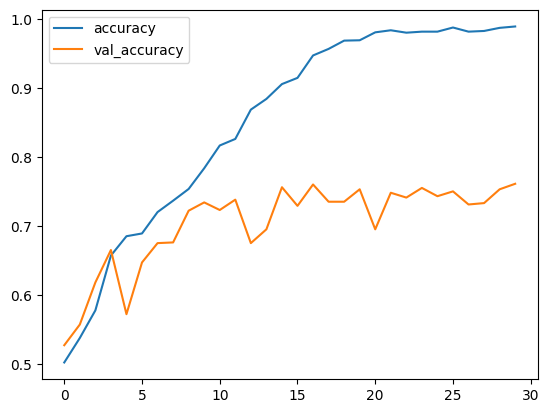

In [26]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

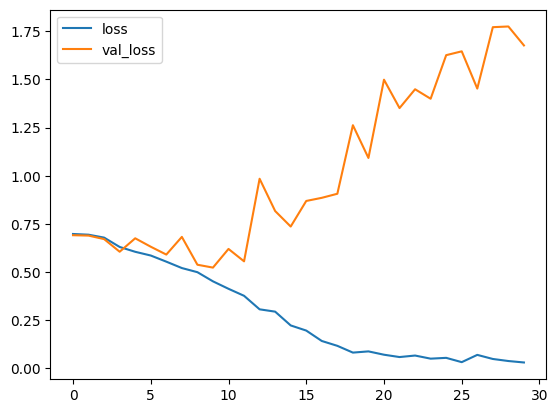

In [27]:
metrics[['loss','val_loss']].plot()
plt.show()

In [28]:
test_model = keras.models.load_model("CNN_benchmark.h5")
test_model.evaluate(test_dataset)

63/63 [==============================] - 5s 60ms/step - loss: 0.5499 - accuracy: 0.7290


[0.5498961210250854, 0.7289999723434448]

The test accuracy is around 70%. Next, we try to make this better by using data augmentation and then transfer learning.

#Data Augmentation

We will be using Data augmentation as a regularization technique to avoid overfitting caused by having too few samples to learn from. In Keras, this can be done by adding a number of data augmentation layers at the
start of your model.

image augmentation layers in [keras](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)!

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom


In [30]:
for images, _ in train_dataset.take(1):
  my_image = images[0]

my_image.shape

TensorShape([180, 180, 3])

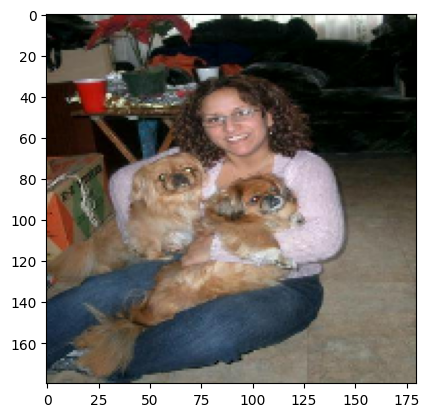

In [31]:
plt.imshow(my_image.numpy().astype("uint8"))
plt.show()

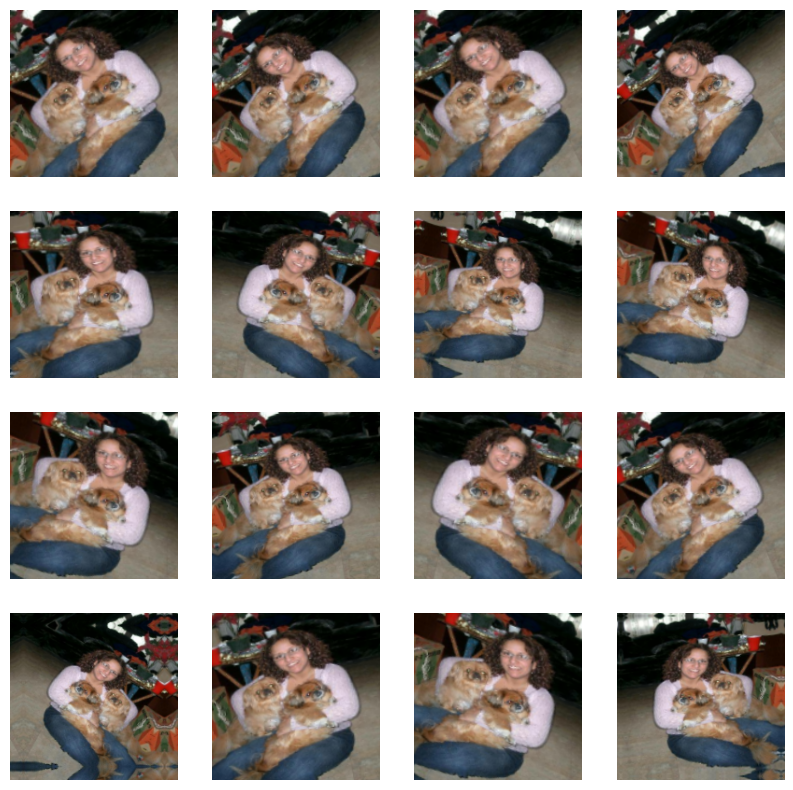

In [32]:
plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_images = data_augmentation(my_image)
    ax = plt.subplot(4, 4, i + 1)

    plt.imshow(augmented_images.numpy().astype("uint8"))
    plt.axis("off")

In [33]:
def CNN_builder_augmented():
  inputs = keras.Input(shape=(180, 180, 3), name='Input')
  x = data_augmentation(inputs)
  x = layers.Rescaling(1./255, name='rescaling')(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", name='conv_layer1')(x)
  x = layers.MaxPooling2D(pool_size=2 , name='pooling1')(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu" , name='conv_layer2')(x)
  x = layers.MaxPooling2D(pool_size=2, name='pooling2')(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", name='conv_layer3')(x)
  x = layers.MaxPooling2D(pool_size=2, name='pooling3')(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", name='conv_layer4')(x)
  x = layers.MaxPooling2D(pool_size=2, name='pooling4')(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", name='conv_layer5')(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(1, activation="sigmoid" , name='output')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_with_augmentation')

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model

We added the dropout layer right after flattening to mitigate overfitting. We also increase the number of epochs because we know the augmented model overfit at later epochs compared to the basic model.

In [34]:
model_augmented = CNN_builder_augmented()
model_augmented.summary()

Model: "CNN_with_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (180, 180, 3)             0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv_layer1 (Conv2D)        (None, 178, 178, 32)      896       
                                                                 
 pooling1 (MaxPooling2D)     (None, 89, 89, 32)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 87, 87, 64)        18496     
                                                                 
 pooling2 (MaxPooling2D)     (None, 43, 43, 6

## Model fit


In [35]:
modelcheckpoint  = ModelCheckpoint(filepath="CNN_augmented.h5",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]


In [36]:
history = model_augmented.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callback_list)
# with regularization, we need to run more epochs because the model will overfit slower.

Epoch 1/30
63/63 [==============================] - 9s 90ms/step - loss: 0.7008 - accuracy: 0.4905 - val_loss: 0.6926 - val_accuracy: 0.6030


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6941 - accuracy: 0.4905 - val_loss: 0.6922 - val_accuracy: 0.6080
Epoch 3/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6939 - accuracy: 0.5205 - val_loss: 0.6899 - val_accuracy: 0.5660
Epoch 4/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6915 - accuracy: 0.5320 - val_loss: 0.6908 - val_accuracy: 0.5360
Epoch 5/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6879 - accuracy: 0.5410 - val_loss: 0.6829 - val_accuracy: 0.5900
Epoch 6/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6875 - accuracy: 0.5475 - val_loss: 0.7028 - val_accuracy: 0.5000
Epoch 7/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6723 - accuracy: 0.5945 - val_loss: 0.7304 - val_accuracy: 0.5030
Epoch 8/30
63/63 [==============================] - 6s 86ms/step - loss: 0.6621 - accuracy: 0.6080 - val_loss: 1.1215 - val_accuracy: 0.5090
Epoch 9/30
63

## Model Evaluate

In [37]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.700831,0.4905,0.692610,0.603
1,0.694083,0.4905,0.692185,0.608
2,0.693891,0.5205,0.689941,0.566
3,0.691548,0.5320,0.690787,0.536
4,0.687889,0.5410,0.682904,0.590


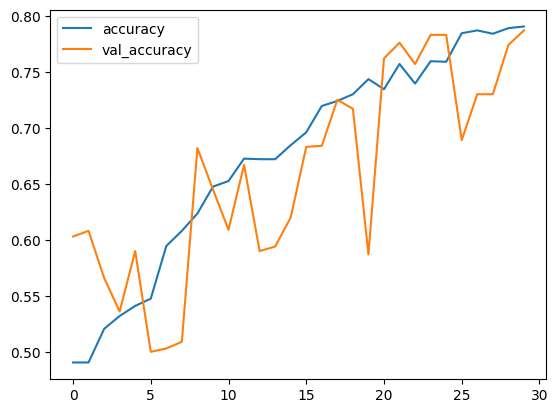

In [38]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

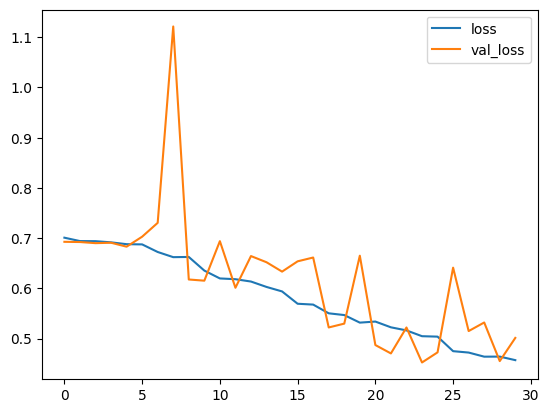

In [39]:
metrics[['loss','val_loss']].plot()
plt.show()

In [40]:
test_model = keras.models.load_model("CNN_augmented.h5")
test_model.evaluate(test_dataset)

ValueError: ignored

In [41]:
test_model = keras.models.load_model("CNN_benchmark.h5")
test_model.evaluate(test_dataset)

63/63 [==============================] - 2s 32ms/step - loss: 0.5499 - accuracy: 0.7290


[0.5498960614204407, 0.7289999723434448]

With data augmentation, the test accuracy increased to 72%. Next, we try transfer learning.

---
---

# Transfer Learning: leveraging a pretrained model

## Feature extraction
Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

In the following section, we will be using VGG16 architecture.

In [42]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels**

In [44]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # this scales pixel values to an appropriate range.
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [45]:
test_features.shape
# recall, the last output in vgg16 has shape (None, 5,5,512)

(2000, 5, 5, 512)

In [46]:
test_labels.shape

(2000,)

**Defining and training the densely connected classifier**

We could define our own CNN builder function, but we are leveraging from an strong model, we only run this once. (You can try different versions)

In [47]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [48]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               1638528   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1638657 (6.25 MB)
Trainable params: 1638657 (6.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
12800*128+128

1638528

### Model fit

In [50]:
modelcheckpoint  = ModelCheckpoint(filepath="CNN_feature_extraction_vgg16.h5",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

In [51]:
history = model.fit(train_features,train_labels,
                              epochs=20, validation_data=(val_features, val_labels),
                              callbacks=callback_list)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 10.5030 - accuracy: 0.9305 - val_loss: 8.2666 - val_accuracy: 0.9340
Epoch 2/20
27/63 [===========>..................] - ETA: 0s - loss: 3.0896 - accuracy: 0.9745

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 7ms/step - loss: 3.2535 - accuracy: 0.9755 - val_loss: 3.7911 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.9047 - accuracy: 0.9825 - val_loss: 4.0727 - val_accuracy: 0.9690
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.9920 - val_loss: 2.8122 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8362 - accuracy: 0.9925 - val_loss: 4.5489 - val_accuracy: 0.9710
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5456 - accuracy: 0.9905 - val_loss: 2.8276 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.7273 - accuracy: 0.9920 - val_loss: 3.0396 - val_accuracy: 0.9720
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 0.5100 - accuracy: 0.9940 - val_loss: 2.1388 - val_accuracy: 0.9810
Epoch 9/20
63/63 [=============

### Model Evaluate

In [52]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,10.503000,0.9305,8.266595,0.934
1,3.253514,0.9755,3.791121,0.970
2,1.904695,0.9825,4.072670,0.969
3,0.690897,0.9920,2.812218,0.976
4,0.836159,0.9925,4.548903,0.971


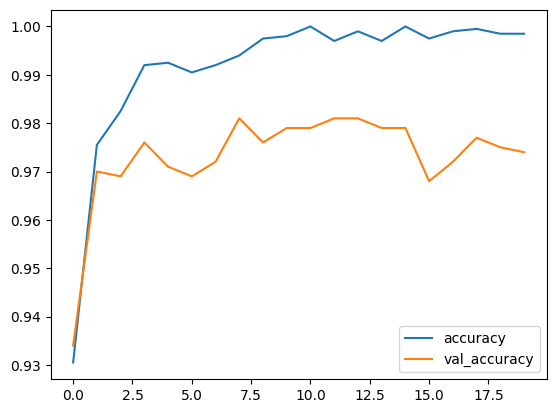

In [53]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

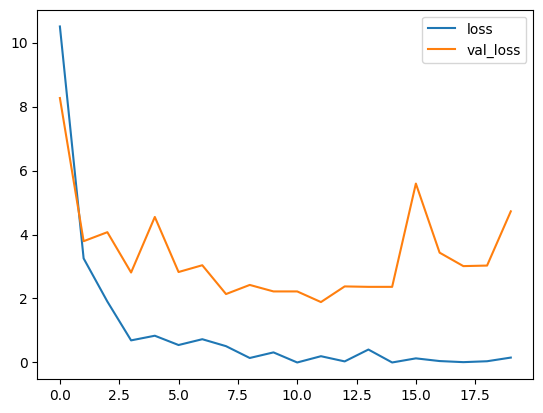

In [54]:
metrics[['loss','val_loss']].plot()
plt.show()

In [55]:
test_model = keras.models.load_model("CNN_feature_extraction_vgg16.h5")
test_model.evaluate(test_features, test_labels)

63/63 [==============================] - 1s 6ms/step - loss: 4.5285 - accuracy: 0.9710


[4.528458118438721, 0.9710000157356262]

The accuracy in the test set is around 96% which is excellent! however, it seems that we are overfitting from the very early epochs. We could use data augmentation to see if it helps to mitigate overfitting.

## Fine-tuning a pretrained model

**Unfreezing the last four layers**

In [56]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [57]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [58]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # we pick very low learning rate to limit the magnitude of changes we make to the last 3 conv layers we are fine-tuning.
              metrics=["accuracy"])

In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1638

### Model fit

In [61]:
modelcheckpoint  = ModelCheckpoint(filepath="CNN_fine_tuning_vgg16.h5",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

In [62]:
history = model.fit(train_dataset,
                              epochs=30, validation_data=validation_dataset,
                              callbacks=callback_list)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 4.0225 - accuracy: 0.7765

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 13s 179ms/step - loss: 4.0225 - accuracy: 0.7765 - val_loss: 0.7645 - val_accuracy: 0.9130
Epoch 2/30
63/63 [==============================] - 11s 177ms/step - loss: 0.8385 - accuracy: 0.9185 - val_loss: 0.5036 - val_accuracy: 0.9420
Epoch 3/30
63/63 [==============================] - 11s 164ms/step - loss: 0.4311 - accuracy: 0.9500 - val_loss: 0.5156 - val_accuracy: 0.9460
Epoch 4/30
63/63 [==============================] - 13s 196ms/step - loss: 0.2469 - accuracy: 0.9710 - val_loss: 0.3627 - val_accuracy: 0.9560
Epoch 5/30
63/63 [==============================] - 12s 192ms/step - loss: 0.1473 - accuracy: 0.9800 - val_loss: 0.3656 - val_accuracy: 0.9560
Epoch 6/30
63/63 [==============================] - 11s 172ms/step - loss: 0.1111 - accuracy: 0.9860 - val_loss: 0.3800 - val_accuracy: 0.9600
Epoch 7/30
63/63 [==============================] - 13s 195ms/step - loss: 0.0424 - accuracy: 0.9940 - val_loss: 0.3538 - val_accuracy: 0.9670
Epoch 8/30

### Model Evaluate

In [63]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,4.022546,0.7765,0.764473,0.913
1,0.838514,0.9185,0.503560,0.942
2,0.431107,0.9500,0.515582,0.946
3,0.246944,0.9710,0.362718,0.956
4,0.147327,0.9800,0.365595,0.956


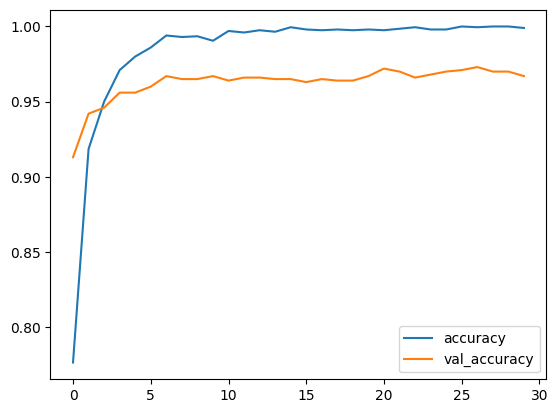

In [64]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

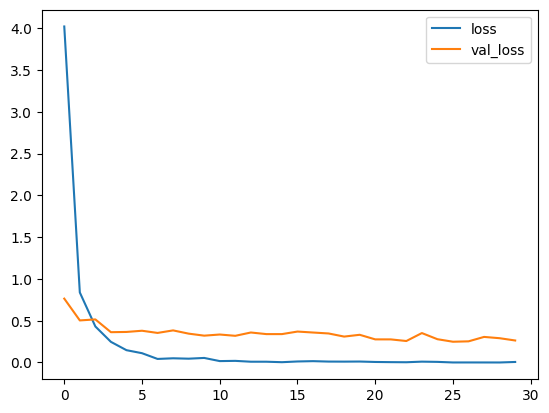

In [65]:
metrics[['loss','val_loss']].plot()
plt.show()

In [66]:
test_model = keras.models.load_model("CNN_fine_tuning_vgg16.h5")
test_model.evaluate(test_dataset)

63/63 [==============================] - 7s 93ms/step - loss: 0.3609 - accuracy: 0.9705


[0.36094796657562256, 0.9704999923706055]

# Model Predictions

For visualization purposes, let's work with the fine_tuned model where the imputs are real images. Let's go ahead and make some predictions with that and look at the confusion matrix.

In [67]:
model = keras.models.load_model("CNN_fine_tuning_vgg16.h5")
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1638

Remember, the test_dataset is a tf.data.Data object.

In [68]:
test_dataset.class_names

['cat', 'dog']

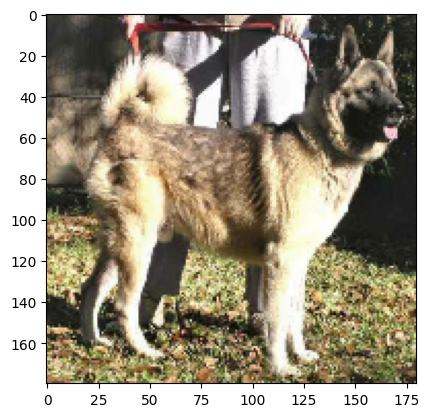

In [69]:
# every single time that you run tf.data.Data, it will shuffle the data.
for image, _ in test_dataset.take(1): # take(N) allows to sample N batches from the dataset.
  plt.imshow(image[1].numpy().astype("uint8"))


In [70]:
# Very important!!! we need to make lables and predictions and images, all in one cell to avoid shuffling.
y_test     = np.array([])
pred_test  = np.array([])
all_images = [] # we want to see which image was misclassified by this monster model :))

for x , y in test_dataset:
  y_test     = np.concatenate([y_test, y])
  pred_test  = np.concatenate([pred_test, model.predict(x, verbose=0).reshape(-1,)])
  all_images.append(x)

In [71]:
test_images = np.concatenate(all_images)
test_images.shape

(2000, 180, 180, 3)

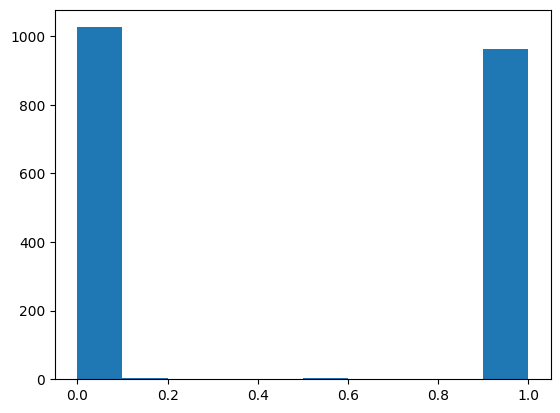

In [72]:
plt.hist(pred_test)
plt.show()

let's generate prediction classes:
* For binary classification, np.where(y_pred > threshold, 1,0)
* For multiclass classification, np.argmax(predictions, axis=1)

https://stackoverflow.com/questions/68776790/model-predict-classes-is-deprecated-what-to-use-instead




In [73]:
predictions = np.where(pred_test >0.5,1,0).reshape(-1,)

In [74]:
from sklearn.metrics import classification_report,confusion_matrix

In [75]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1000
         1.0       0.99      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [76]:
confusion_matrix(y_test,predictions)

array([[986,  14],
       [ 45, 955]])

In [77]:
misclass = y_test !=predictions

In [78]:
misclassified_images = [i for i, x in enumerate(misclass) if x==True]
misclassified_images[:10]

[47, 80, 92, 126, 175, 178, 179, 182, 322, 401]

Let's look at some of these misclassified images :)

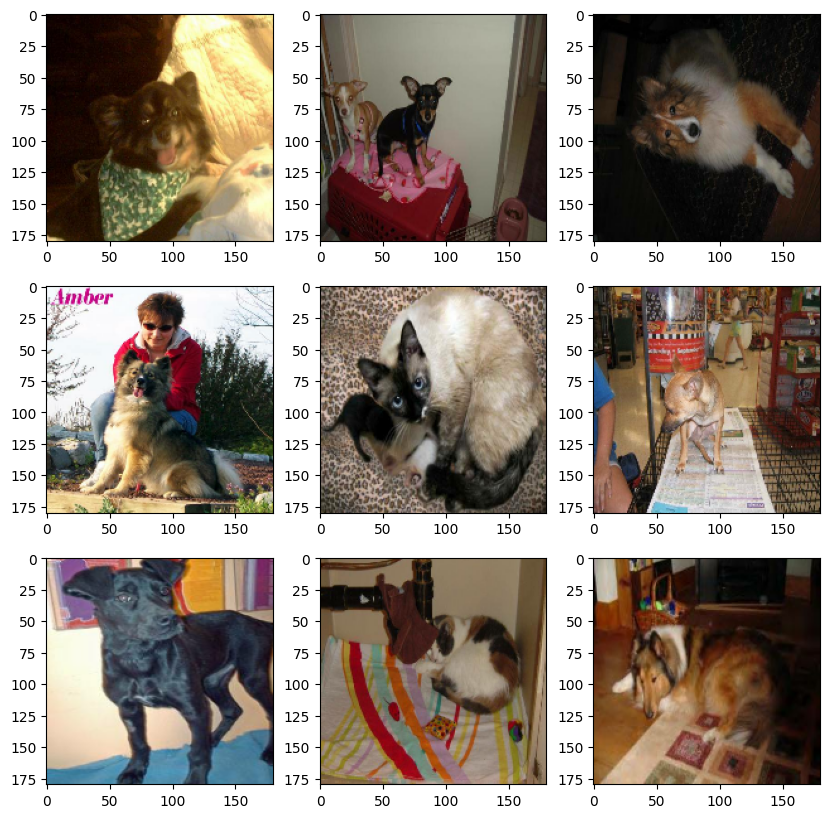

In [79]:
plt.figure(figsize=(10,10))
for i , number in enumerate(misclassified_images[:9]):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(test_images[number].astype("uint8"))
plt.show()

# Done!